# Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import Rb87Cs133

import scipy.constants

import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200

%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

# Define Constants

In [31]:
H_BAR = scipy.constants.hbar

I1 = Rb87Cs133["I1"]
I2 = Rb87Cs133["I2"]
D_0 = Rb87Cs133["d0"]
print(D_0)
N_MAX=1

I = 0 #W/m^2
E = 0 #V/m

B_MIN = 0.01 # G
B_MAX = 300 # G
B_STEPS = 50

4.0861590000000005e-30


# Build and Diagonalise Hamiltonian for many B

In [3]:
H0,Hz,Hdc,Hac = hamiltonian.build_hamiltonians(N_MAX, Rb87Cs133, zeeman=True, Edc=True, ac=True)

B = np.linspace(B_MIN, B_MAX, B_STEPS) * 1e-4 #T

H = H0[..., None]+\
    Hz[..., None]*B+\
    Hdc[..., None]*E+\
    Hac[..., None]*I
H = H.transpose(2,0,1)

energies, states = eigh(H)

energies, states, labels = calculate.sort_by_state(energies, states, N_MAX, Rb87Cs133)

# Helper Functions

In [4]:
def label_to_state_no(N,MF,k):
    for i, label in enumerate(labels):
        if label[0] == N and label[1] == MF and label[2] == k:
            return i

def state_no_to_uncoupled_label(state_no):
    i=0
    I1d = int(I1*2)
    I2d = int(I2*2)
    for n in range(0, N_MAX + 1):
        for mn in range(n,-(n+1),-1):
            for mi1 in range(I1d,-I1d-1,-2):
                for mi2 in range(I2d,-I2d-1,-2):
                    if i == state_no:
                        return (n,mn,mi1/2,mi2/2)
                    i+=1

# Plot energies over B for N=1 and N=2, highlighting available transitions from spin stretched group state

<IPython.core.display.Javascript object>


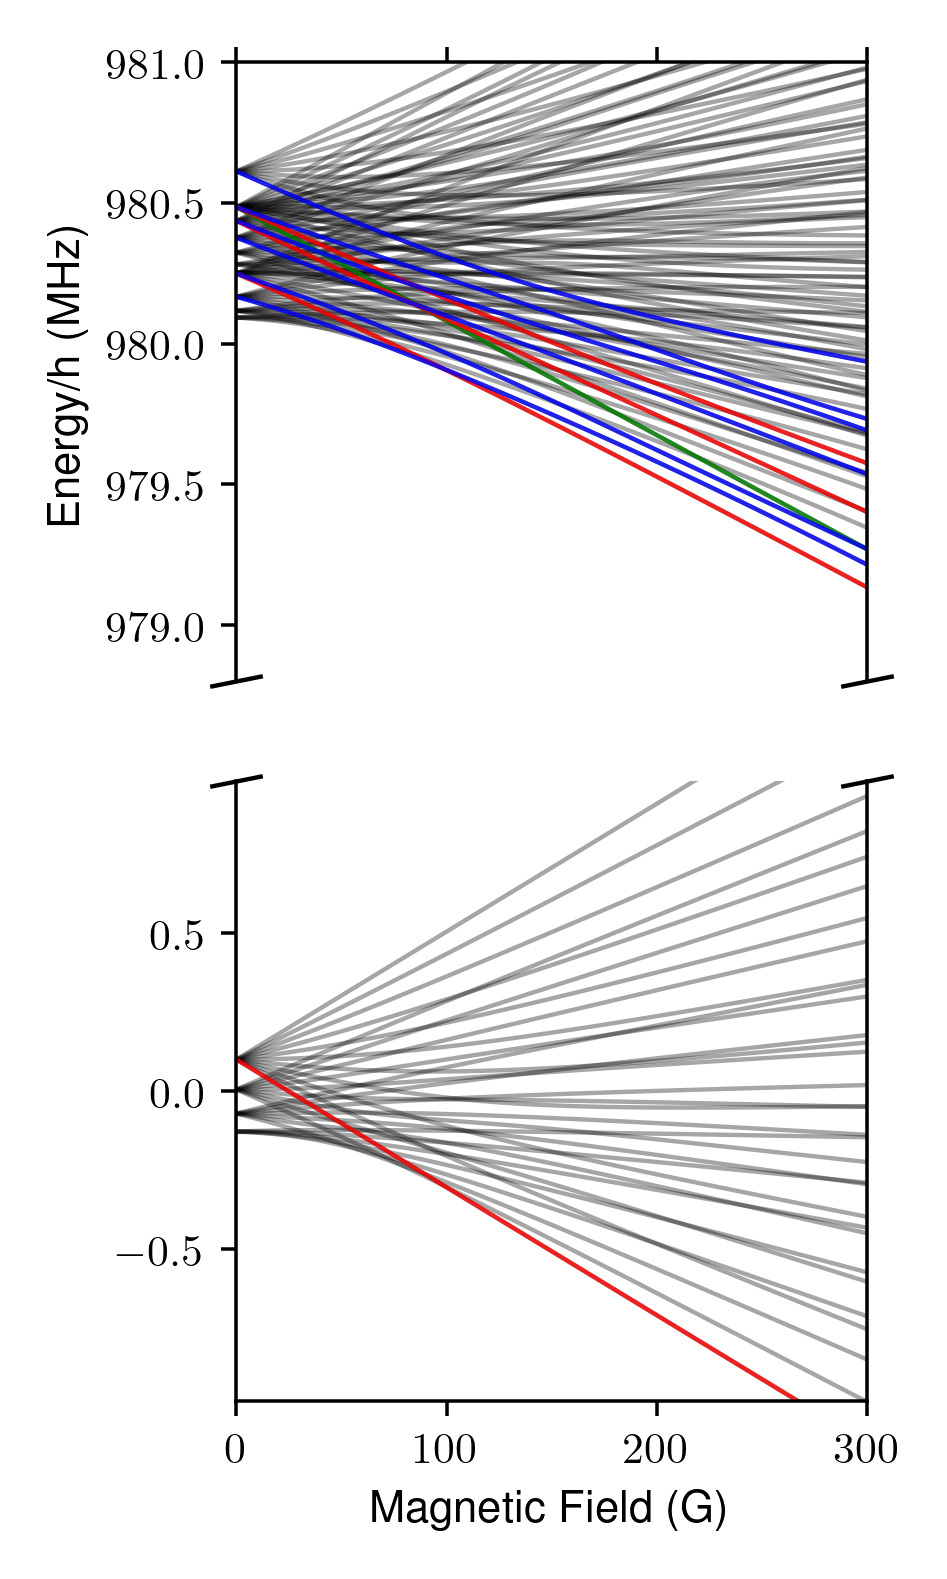

/Users/tom/Code/project/rigidStark/venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [5]:
fig, (ax_up, ax_down) = plt.subplots(2,1,sharex=True,figsize=(3,5),dpi=200)

ax_up.plot(B*1e4, energies*1e-6/scipy.constants.h, color='k', linewidth=1, alpha=0.35)
ax_down.plot(B*1e4, energies*1e-6/scipy.constants.h, color='k', linewidth=1, alpha=0.35)

# Highlight available transitions from (0,5,0)
for i, energy in enumerate(energies.T):
    if (labels[i]==[0,5,0]).all() or (labels[i][0] == 1 and labels[i][1] in [4,5,6]):
        c=['b','r','g'][int(labels[i][1]-4)]
        a=0.8
        ax_up.plot(B*1e4, energy*1e-6/scipy.constants.h, color=c, linewidth=1, alpha=a)
        ax_down.plot(B*1e4, energy*1e-6/scipy.constants.h, color=c, linewidth=1, alpha=a)
        
ax_up.set_xlim(0, B_MAX)
ax_up.set_ylim(978.8, 981.0)
ax_down.set_ylim(-0.98, 0.98)
ax_up.set_ylabel("Energy/h (MHz)")
ax_down.set_xlabel("Magnetic Field (G)")

# Split axes formatting
ax_up.spines.bottom.set_visible(False)
ax_down.spines.top.set_visible(False)
ax_up.xaxis.tick_top()
ax_up.tick_params(labeltop=False)
ax_down.xaxis.tick_bottom()
d = .2  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax_up.plot([0, 1], [0, 0], transform=ax_up.transAxes, **kwargs)
ax_down.plot([0, 1], [1, 1], transform=ax_down.transAxes, **kwargs)

fig.show()

# State mixing composition over B

<IPython.core.display.Javascript object>


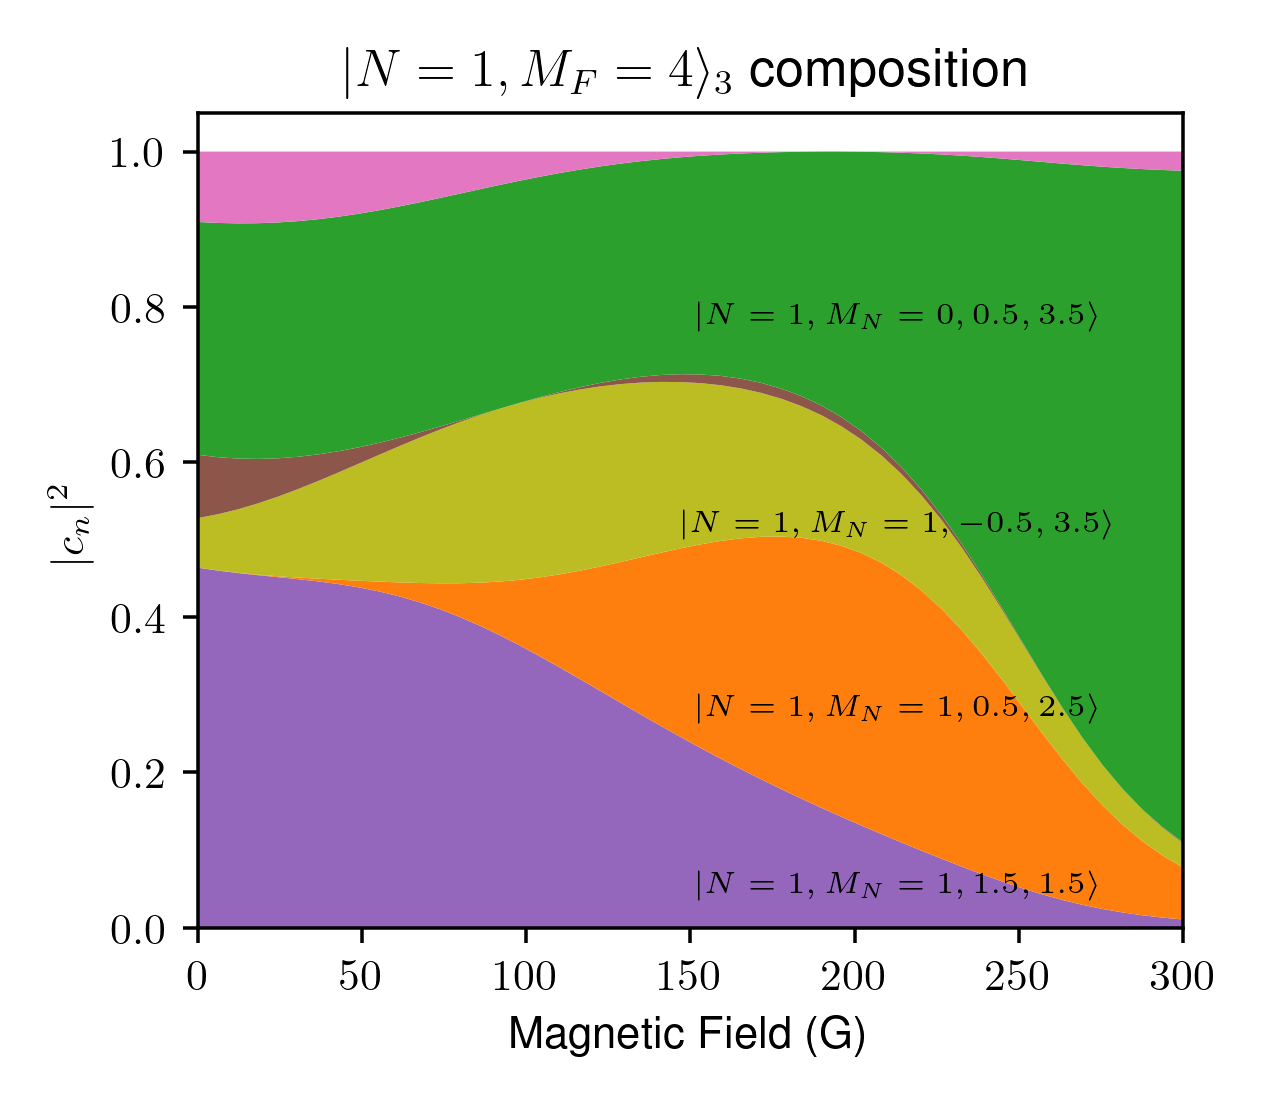

In [6]:
fig, ax = plt.subplots()

state_label_to_plot = (1, 4, 3)
state_num_to_plot = label_to_state_no(*state_label_to_plot)

ax.stackplot(B*1e4, np.abs(states[:, :, state_num_to_plot].T)**2)

cumulative=0
for component_state_index, component_state_coef in enumerate(states[int(B_STEPS*0.7), :, state_num_to_plot]):
    if np.abs(component_state_coef) > 0.25:
        component_state_label = state_no_to_uncoupled_label(component_state_index)
        component_state_label_string = r'$|N={},M_N={},{},{}\rangle$'.format(*component_state_label)
        component_state_fraction = np.abs(component_state_coef)**2
        ax.text(B[int(B_STEPS*0.7)]*1e4, cumulative+component_state_fraction/2, component_state_label_string,
                va='center', ha='center', fontsize='x-small')
        cumulative += component_state_fraction

ax.set_ylabel(r"$|c_n|^2$")
ax.set_xlabel("Magnetic Field (G)")
ax.set_ylim(0, 1.05)
ax.set_xlim(0, B_MAX)
ax.set_title(r'$|N={},M_F={}\rangle_{}$ composition'.format(*state_label_to_plot))

fig.show()

# A4 all states mixing plots

<IPython.core.display.Javascript object>


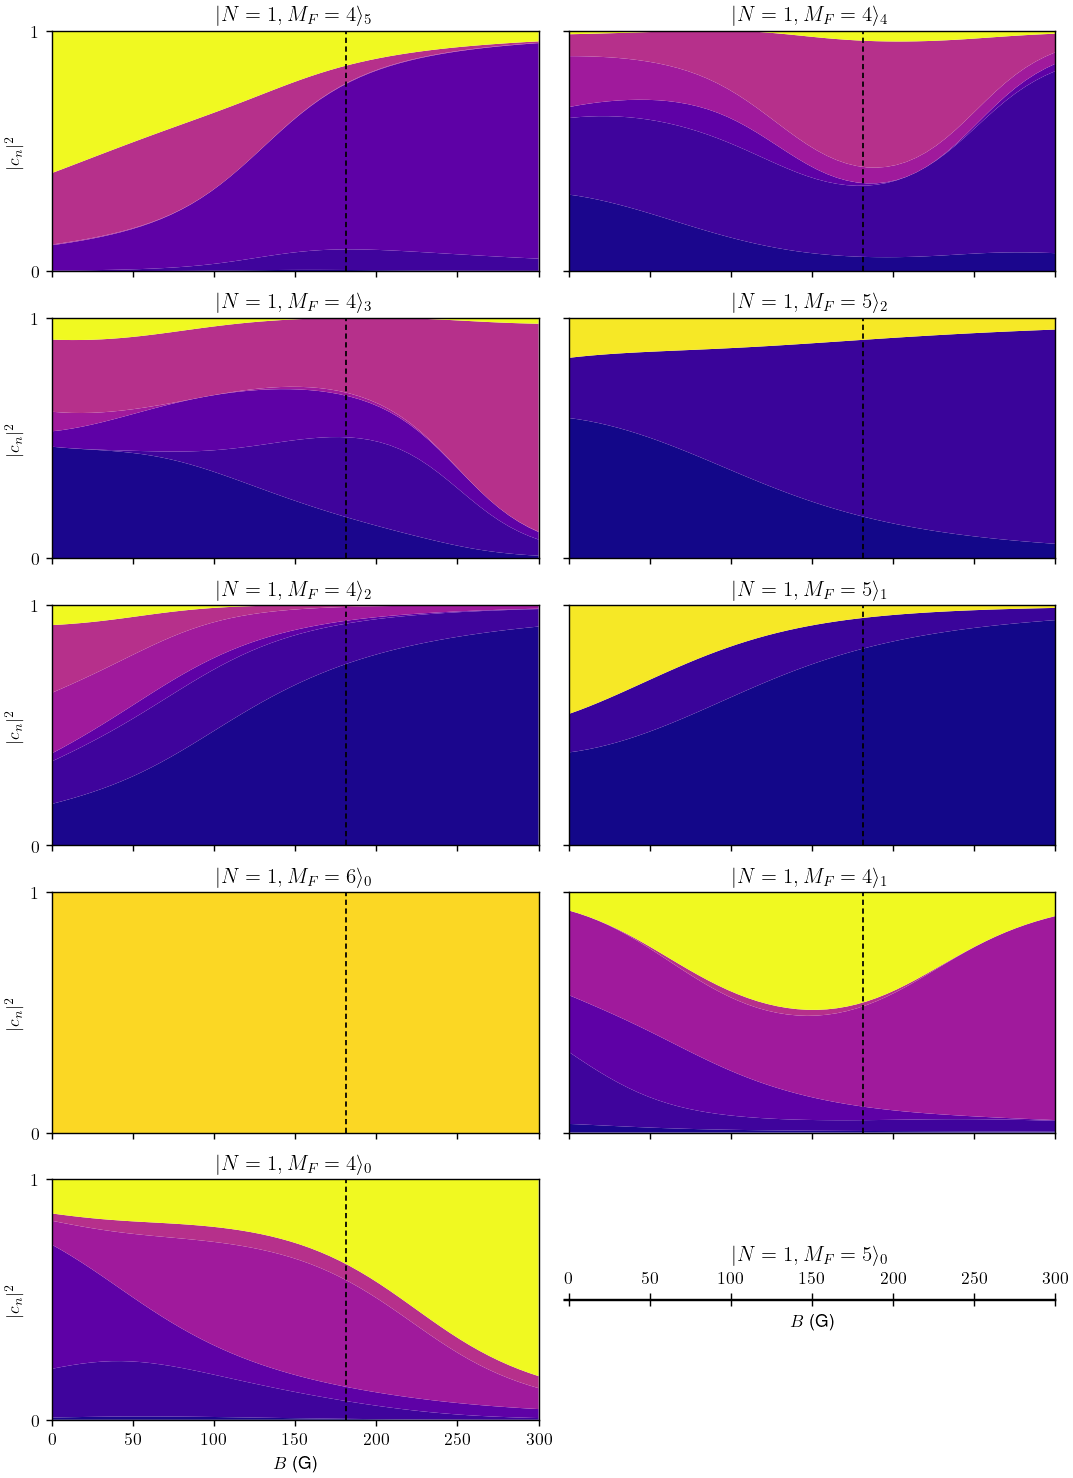

In [39]:
# Set DPI to 300 for print quality
fig, axs = plt.subplots(5, 2, figsize=(8.5,11.7), dpi=80, sharex=True, sharey=True, layout="constrained")

state_labels_to_plot = np.array([[(1, 4, 5), (1, 4, 4)],
                                 [(1, 4, 3), (1, 5, 2)],
                                 [(1, 4, 2), (1, 5, 1)],
                                 [(1, 6, 0), (1, 4, 1)],
                                 [(1, 4, 0), (1, 5, 0)]])

for v, axrow in enumerate(axs):
    for h, ax in enumerate(axrow):
        state_label_to_plot = state_labels_to_plot[v][h]
        state_num_to_plot = label_to_state_no(*state_label_to_plot)

        state_coeffs_to_plot = np.abs(states[:, 32:128, state_num_to_plot].T)**2
        
        color_map = plt.cm.plasma
        colors = color_map(np.linspace(0, 1, len(state_coeffs_to_plot))) #* [0.9,0.9,0.9,1]
        colors_special = color_map(np.linspace(0.92, 1, 3))
        colors[[0,32,64]] = colors_special

        ax.stackplot(B*1e4, state_coeffs_to_plot, colors=colors)

        ax.set_ylim(0, 1)
        ax.set_xlim(0, B_MAX)
        ax.set_title(r'$|N={},M_F={}\rangle_{}$'.format(*state_label_to_plot))
        ax.axvline(x=181.5,dashes=(3, 2),color='k',linewidth=1)

[ax.set_xlabel(r"$B$ (G)") for ax in axs[4,:]]
[ax.set_ylabel(r"$|c_n|^2$") for ax in axs[:,0]]

fig.show()

# Transition Dipole Moments

<IPython.core.display.Javascript object>


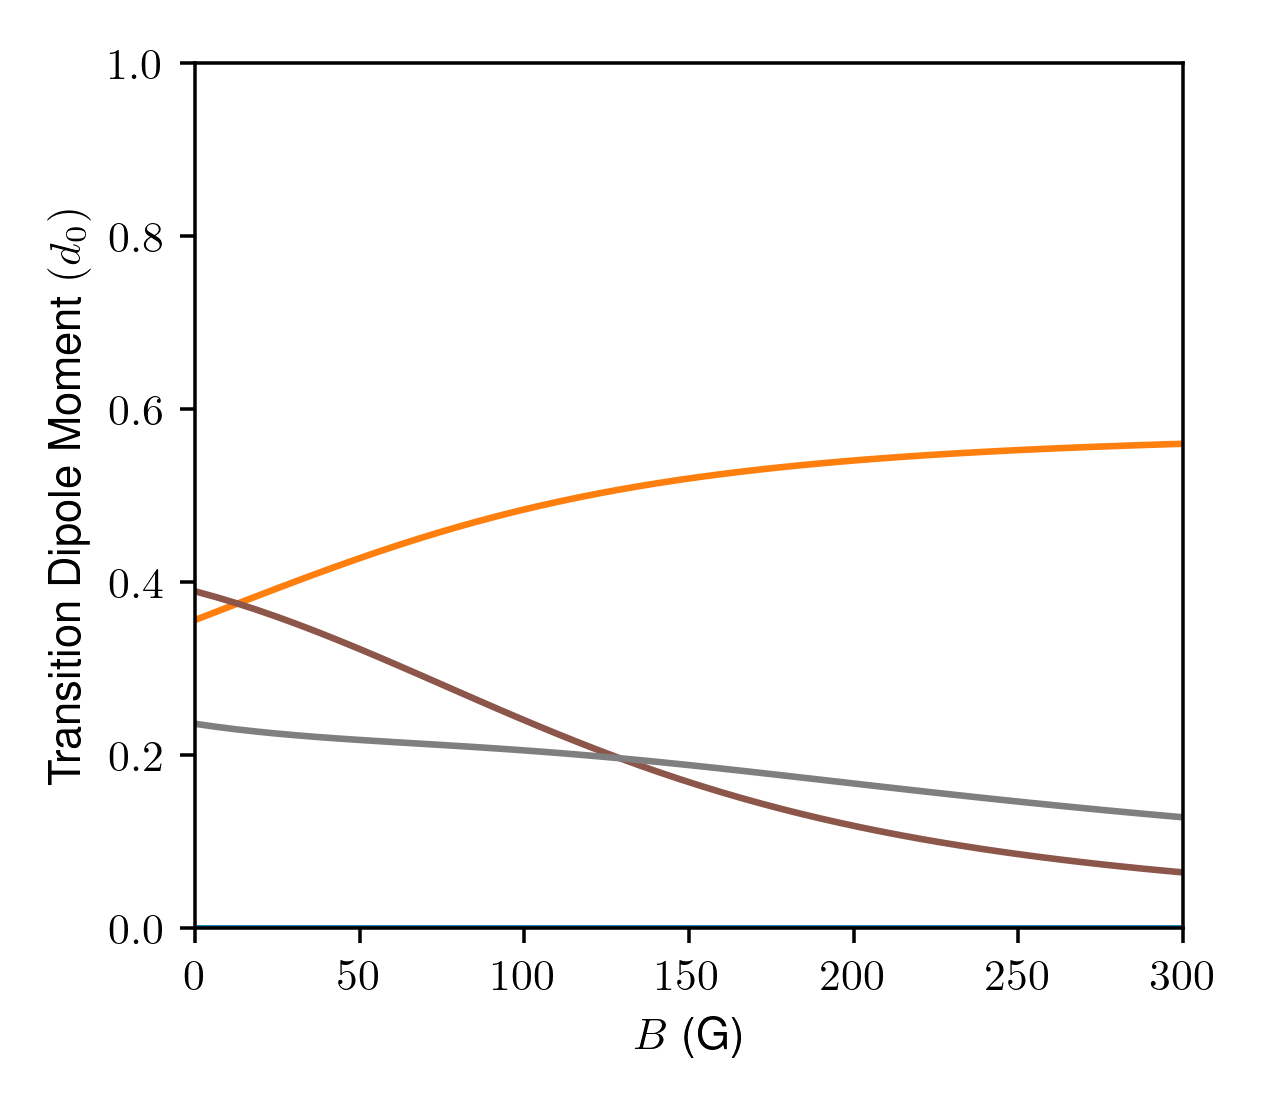

In [135]:
"""
left = np.conj(states[40,:,initial_state_position])
right = states[40,:,all_state_positions].T
mine1 = np.einsum('i,ij,jk->k',left,dipole_op,right).real
mine2 = (np.conj(states[40,:,initial_state_position]) @ dipole_op @ states[40,:,all_state_positions].T).real
theirs = calculate.transition_dipole_moment(N_MAX,I1,I2,M,states[40],initial_state_position,locs=all_state_positions)
"""

initial_state_label = (0,5,0)
initial_state_position = label_to_state_no(*initial_state_label)

all_state_labels = [(0, 5, 0), (1, 5, 0), (1, 4, 0), (1, 4, 1), (1, 6, 0), (1, 5, 1), (1, 4, 2), (1, 5, 2), (1, 4, 3), (1, 4, 4), (1, 4, 5)]
all_state_positions = np.array([label_to_state_no(N,MF,k) for N,MF,k in all_state_labels])

M=0
dipole_op = calculate.dipole(N_MAX,I1,I2,1,M)


mine2big = (states[:,:,all_state_positions].conj().transpose(0,2,1) @ (dipole_op @ states[:,:,all_state_positions])).real
mine2 = mine2big[40,initial_state_position,:]

mine3big = (states.conj().transpose(0,2,1) @ dipole_op @ states).real
mine3 = mine3big[40,initial_state_position,all_state_positions]
mine3reduced=mine3big[40][:,all_state_positions][all_state_positions]

fig,ax = plt.subplots()
ax.plot(B*1e4,np.abs(mine2big[:,initial_state_position,:]))
ax.set_xlabel(r"$B$ (G)")
ax.set_ylabel(r"Transition Dipole Moment $(d_0)$")
ax.set_xlim(0, B_MAX)
ax.set_ylim(0, 1)
fig.show()

# State mixing table at max B

In [8]:
state_labels = [(1.0, 4.0, 5.0), (1.0, 4.0, 4.0), (1.0, 4.0, 3.0), (1.0, 5.0, 2.0), (1.0, 4.0, 2.0), (1.0, 5.0, 1.0), (1.0, 6.0, 0.0), (1.0, 4.0, 1.0), (1.0, 4.0, 0.0), (1.0, 5.0, 0.0)]
state_positions = np.array([label_to_state_no(N,MF,k) for N,MF,k in state_labels])

for state_label, state_position in zip(state_labels, state_positions):
    print(state_label, end=': ')
    for state_index, state_coef in enumerate(states[B_STEPS-1, :, state_position]):
        if np.abs(state_coef) > 0.001:
            print(f'{state_coef.real:=+6.3f}*{state_no_to_uncoupled_label(state_index)}', end=" ")
    print()

(1.0, 4.0, 5.0): -0.031*(1, 1, 1.5, 1.5) -0.225*(1, 1, 0.5, 2.5) -0.947*(1, 1, -0.5, 3.5) -0.031*(1, 0, 1.5, 2.5) +0.080*(1, 0, 0.5, 3.5) -0.211*(1, -1, 1.5, 3.5) 
(1.0, 4.0, 4.0): +0.273*(1, 1, 1.5, 1.5) +0.870*(1, 1, 0.5, 2.5) -0.174*(1, 1, -0.5, 3.5) +0.219*(1, 0, 1.5, 2.5) +0.278*(1, 0, 0.5, 3.5) -0.113*(1, -1, 1.5, 3.5) 
(1.0, 4.0, 3.0): -0.103*(1, 1, 1.5, 1.5) -0.259*(1, 1, 0.5, 2.5) +0.177*(1, 1, -0.5, 3.5) +0.036*(1, 0, 1.5, 2.5) +0.930*(1, 0, 0.5, 3.5) -0.157*(1, -1, 1.5, 3.5) 
(1.0, 5.0, 2.0): -0.245*(1, 1, 1.5, 2.5) -0.944*(1, 1, 0.5, 3.5) -0.221*(1, 0, 1.5, 3.5) 
(1.0, 4.0, 2.0): -0.954*(1, 1, 1.5, 1.5) +0.270*(1, 1, 0.5, 2.5) -0.040*(1, 1, -0.5, 3.5) +0.121*(1, 0, 1.5, 2.5) -0.026*(1, 0, 0.5, 3.5) +0.005*(1, -1, 1.5, 3.5) 
(1.0, 5.0, 1.0): +0.968*(1, 1, 1.5, 2.5) -0.225*(1, 1, 0.5, 3.5) -0.111*(1, 0, 1.5, 3.5) 
(1.0, 6.0, 0.0): +1.000*(1, 1, 1.5, 3.5) 
(1.0, 4.0, 1.0): -0.061*(1, 1, 1.5, 1.5) +0.213*(1, 1, 0.5, 2.5) +0.054*(1, 1, -0.5, 3.5) -0.921*(1, 0, 1.5, 2.5) +0.025*(

# Rabi oscillations
$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
$$
$$
H_{ij} = \frac{\hbar}{2} \Omega_{ij} \odot T_{ij}
$$
$$
\Omega_{ij} = \frac{E_0}{\hbar} \bra{i} \mathbf{\hat{d}} \cdot \mathbf{\hat{\epsilon}} \ket{j}
$$
$$
T_{ij} = e^{i(w_{ij}-w)t} + e^{i(w_{ij}+w)t}
$$

<IPython.core.display.Javascript object>


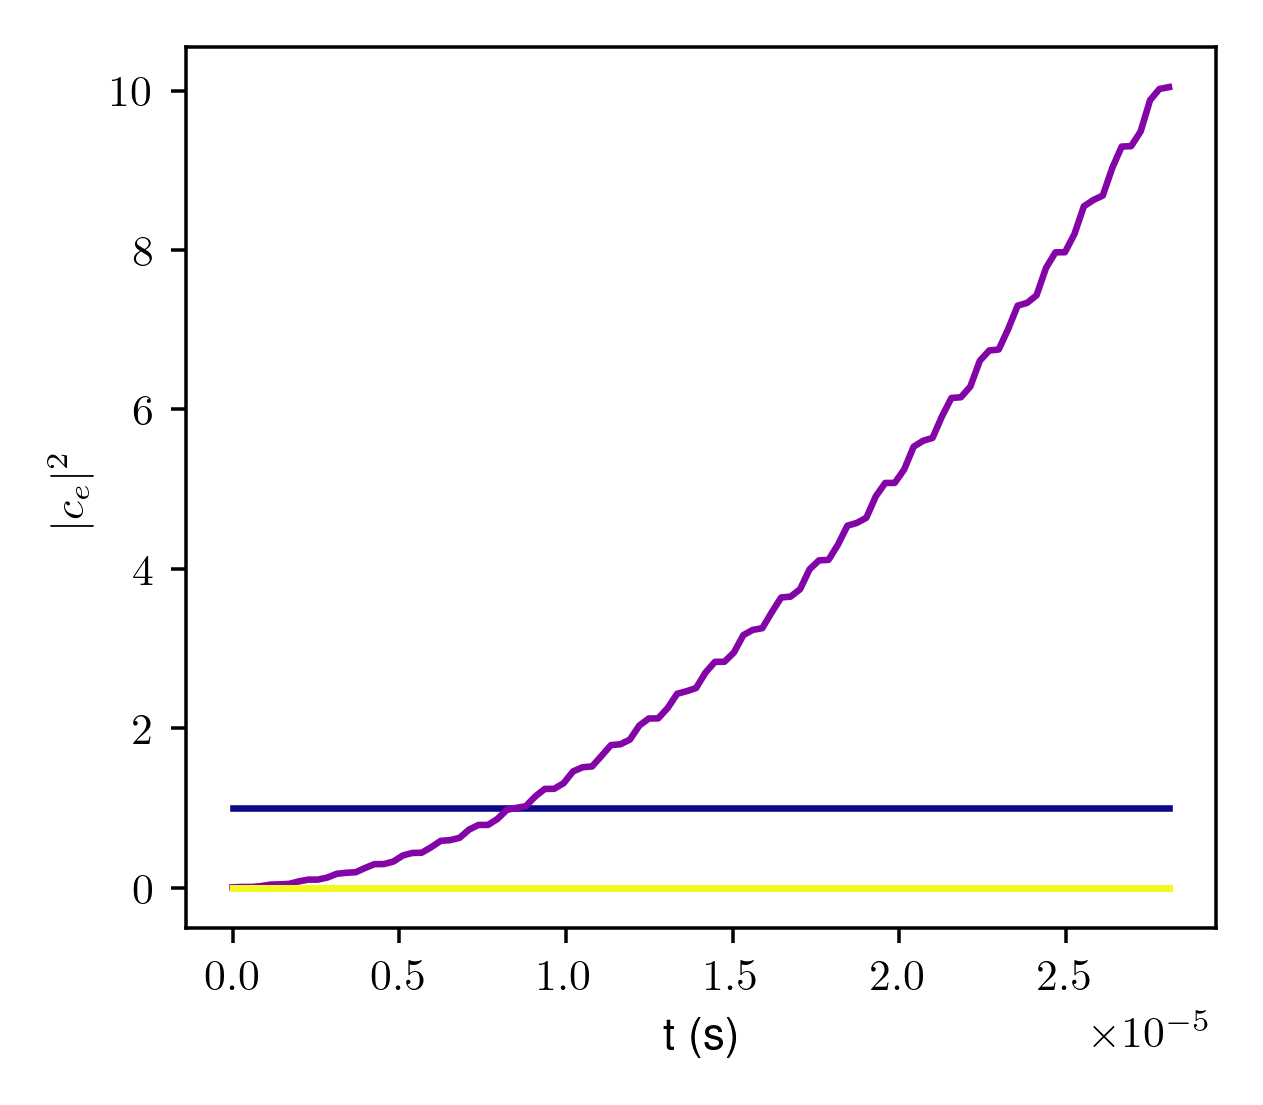

[[ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j -1.62255841e-45+0.j -1.88250224e-30+0.j  0.00000000e+00+0.j -1.17107798e-30+0.j -4.13024305e-42+0.j -2.01972087e-44+0.j -2.28774678e-42+0.j  8.92117298e-44+0.j -3.86500359e-43+0.j -1.58072236e-33+0.j -1.72707998e-43+0.j -4.72021354e-44+0.j -2.17952678e-43+0.j  4.62910239e-43+0.j  3.86793703e-43+0.j -4.36441586e-44+0.j  2.24275210e-31+0.j  4.43746225e-31+0.

In [30]:
fig, ax = plt.subplots()

# Experimental Setup
#INITIAL_STATE = 0
#INTENDED_STATE = 4
POLARISATION = 1 # -1,0,1
DETUNING = 0
E_0 = 10 # V/m
AT_B_NUM = 40

# Get relevant states (N=1, M_F = 4,5,6)
initial_state_label = (0,5,0)
initial_state_position = label_to_state_no(*initial_state_label)

intended_state_label = (1,6,0)
intended_state_position = label_to_state_no(*intended_state_label)

#all_state_labels = [(0, 5, 0), (1, 5, 0), (1, 4, 0), (1, 4, 1), (1, 6, 0), (1, 5, 1), (1, 4, 2), (1, 5, 2), (1, 4, 3), (1, 4, 4), (1, 4, 5)]
#all_state_positions = np.array([label_to_state_no(N,MF,k) for N,MF,k in all_state_labels])
angular = (energies[AT_B_NUM,:]-energies[AT_B_NUM,initial_state_position]).real/H_BAR

driving = angular[intended_state_position] + DETUNING #6.16038893e+09 # Rad/s, 2pi * (KHz 3, MHz 6, GHz 9)

N_STATES = len(angular)
# Construct coupling matrix
dipole_op = calculate.dipole(N_MAX,I1,I2,D_0,POLARISATION)
#dipole_op = calculate.dipole(N_MAX,I1,I2,D_0,POLARISATION) - calculate.dipole(N_MAX,I1,I2,D_0,-POLARISATION)

couplings = states[AT_B_NUM,:,:].conj().T @ (dipole_op @ states[AT_B_NUM,:,:])
print(couplings)
global_coupling = (E_0/H_BAR)
coupling = global_coupling * couplings

# Construct
T_MAX = 2*np.pi / np.abs(coupling[intended_state_position,initial_state_position])
T_STEPS = 100
times, DT = np.linspace(0, T_MAX, num=T_STEPS, retstep=True)

Ts = []
for t in times:
    T  = np.zeros((N_STATES,N_STATES), dtype=np.cdouble)
    for i in range(N_STATES):
        for j in range(N_STATES):
            T[i,j] = np.exp((1j)*(angular[i]-angular[j]-driving)*t) + np.exp((1j)*(angular[i]-angular[j]+driving)*t)
    Ts.append(T)
Ts = np.array(Ts)

# Construct Hamiltonians
H = np.array([H_BAR/2 * np.multiply(coupling, T) for T in Ts])


# Move State

finals = []

state = np.zeros(N_STATES) # initial state
state[initial_state_position] = 1


for i in range(T_STEPS):
    unitary = scipy.linalg.expm(-(1j)*(DT/H_BAR)*H[i])
    state = np.matmul(unitary,state)
    finals.append(np.abs(state)**2)

    
#ax.set_xlim(0,T_MAX)
#ax.set_ylim(0,1)
ax.set_xlabel("t (s)")
ax.set_ylabel("$|c_e|^2$")

colors = plt.cm.plasma(np.linspace(0,1,N_STATES))
for i,final in enumerate(np.array(finals).T):
    ax.plot(times, final, c=colors[i])
fig.show()

# Transfer efficiency

/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_95281/3735843979.py:29: RuntimeWarning: divide by zero encountered in divide
  PI_PULSE_TIMES = 2*np.pi / np.abs(rabis[:,0,INTENDED_STATE])
/Users/tom/Code/project/rigidStark/venv/lib/python3.9/site-packages/numpy/core/function_base.py:153: RuntimeWarning: invalid value encountered in multiply
  y = y * step
/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_95281/3735843979.py:38: RuntimeWarning: invalid value encountered in multiply
  Ts = np.exp((1j)*neg_frequency_part[:,np.newaxis,:,:]*times[:,:,np.newaxis,np.newaxis]) + \
/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_95281/3735843979.py:39: RuntimeWarning: invalid value encountered in multiply
  np.exp((1j)*pos_frequency_part[:,np.newaxis,:,:]*times[:,:,np.newaxis,np.newaxis]) #[bi, ti,i,j]


<IPython.core.display.Javascript object>


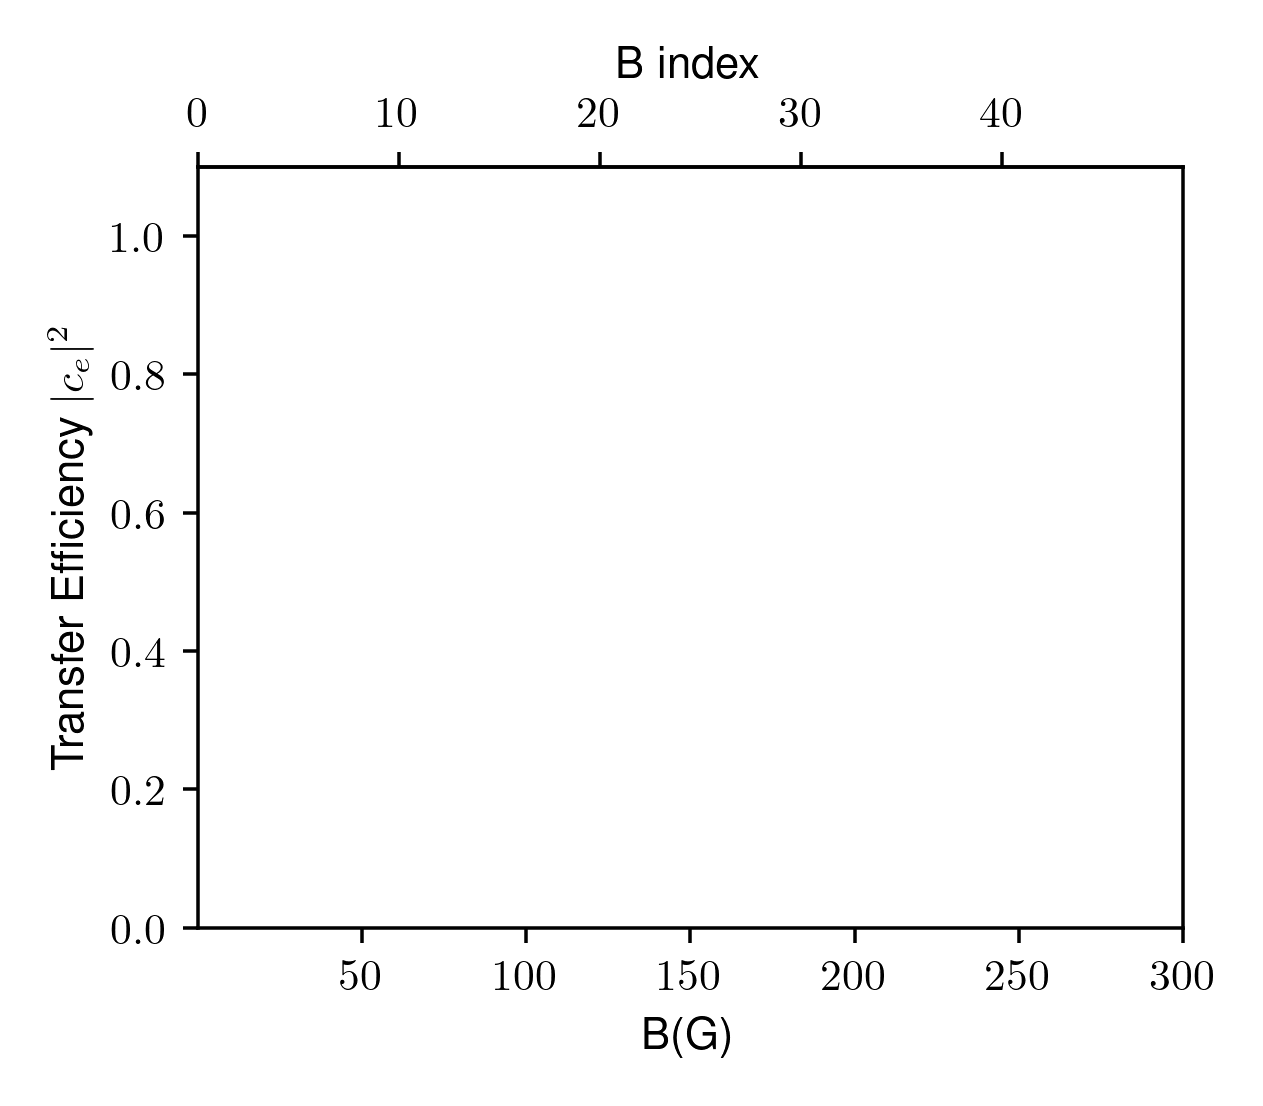

In [10]:
# Experimental Setup
INITIAL_STATE = 0
INTENDED_STATE = 7
POLARISATION = -1 # -1,0,1
DETUNING = 0
E_0 = 10 # V/m

# Get relevant states (N=1, M_F = 4,5,6)
initial_state_label = (0,5,0)
initial_state_position = label_to_state_no(*initial_state_label)

all_state_labels = [(0, 5, 0), (1, 5, 0), (1, 4, 0), (1, 4, 1), (1, 6, 0), (1, 5, 1), (1, 4, 2), (1, 5, 2), (1, 4, 3), (1, 4, 4), (1, 4, 5)]
all_state_positions = np.array([label_to_state_no(N,MF,k) for N,MF,k in all_state_labels])

angular = energies[:,all_state_positions].real/H_BAR # [B_Number, state]
N_STATES = len(all_state_labels)

driving = angular[:, INTENDED_STATE].T-angular[:, 0]+DETUNING #[B_Number]

dipole_op = calculate.dipole(N_MAX,I1,I2,D_0,POLARISATION)

# Construct Rabi coupling part
couplings = states[:,:,all_state_positions].conj().transpose(0,2,1) @ (dipole_op @ states[:,:,all_state_positions])

global_coupling = (E_0/H_BAR)
rabis = global_coupling * couplings

# Construct Time-dependent part
PI_PULSE_TIMES = 2*np.pi / np.abs(rabis[:,initial_state_position,INTENDED_STATE])
T_STEPS = 10000
times, DTs = np.linspace(0, PI_PULSE_TIMES, num=T_STEPS, retstep=True)# [time, B_Number], [B_Number]
times = times.T #[B_Number, time]

wij = angular[:,:,np.newaxis]-angular[:,np.newaxis,:]    #[bi,i,j]
neg_frequency_part = wij-driving[:,np.newaxis,np.newaxis]   #[bi,i,j]
pos_frequency_part = wij+driving[:,np.newaxis,np.newaxis]   #[bi,i,j]

Ts = np.exp((1j)*neg_frequency_part[:,np.newaxis,:,:]*times[:,:,np.newaxis,np.newaxis]) + \
     np.exp((1j)*pos_frequency_part[:,np.newaxis,:,:]*times[:,:,np.newaxis,np.newaxis]) #[bi, ti,i,j]

# Construct overall Hamiltonians
Hs = H_BAR/2 * rabis[:,np.newaxis,:,:] * Ts[:,:,:,:]  #[bi, ti,i,j]


# Initialise states for each B
state_vectors = np.zeros((B_STEPS,N_STATES)) # initial state
state_vectors[:,INITIAL_STATE] = 1

# Churn Differential equation
max_coef = np.zeros((B_STEPS))

Hdts = Hs[:,:,:,:] * DTs[:,np.newaxis,np.newaxis,np.newaxis]

DUs = scipy.linalg.expm(-(1j/H_BAR)*Hdts[:,:,:,:]) # Infitesimal unitary transformations

for t_num in range(T_STEPS):
    state_vectors = np.einsum('bij,bi->bj',DUs[:,t_num,:,:],state_vectors)
    max_coef = np.maximum(max_coef[:], np.abs(state_vectors[:,INTENDED_STATE])**2)

fig, ax = plt.subplots() 
ax.set_xlim(B_MIN,B_MAX)
ax.set_ylim(0,1.1)
ax.set_xlabel("B(G)")
ax.set_ylabel("Transfer Efficiency $|c_e|^2$")


def btoi(b):
    k = (B_MAX-B_MIN)/(B_STEPS-1)
    c = B_MIN
    return (b-c)/k

def itob(i):
    k = (B_MAX-B_MIN)/(B_STEPS-1)
    c = B_MIN
    return k*i+c


secax = ax.secondary_xaxis('top', functions=(btoi, itob))
secax.set_xlabel('B index')

ax.plot(B*1e4, max_coef)

fig.show()